In [1]:
import sys
sys.path.append("../../PythonScripts/")

In [2]:
from prereqs import *

now importing: 
1. numpy as np 
2. matplotlib.pyplot as plt
3. from scipy import stats




## Introduction 

Now that we've familiarized ourselves with MCMC and the Metropolis-Hastings algorithms, we begin to analyze a now-common MCMC algorithm called Gibbs sampler. The Gibbs sampler is in fact a special case of the Metropolis-Hastings algorithm for high dimensional target distributions.

Recommended reading: [Explaining the Gibbs Sampler](http://biostat.jhsph.edu/~mmccall/articles/casella_1992.pdf)


## Two-stage Gibbs sampler algorithm 

The *two-stage* Gibbs sampler creates a Markov chain from a joint distribution in the following way. If two random variables $X$ and $Y$ have joint density $f(x,y)$, with corresponding conditional densities $f_{Y|X}$ and $f_{X|Y}$, the two stage Gibbs sampler generates a Markov chain $(X_t, y_i)$ by generating $y_i$ from conditional density $f_{Y|X}$ and then generating $X_t$ from conditional density $f_{X|Y}$.

The **two-stage Gibbs sampler algorithm** as described Robert & Casella goes as follows


`Take` $X_0 = x_0$ 

For $t = 1, 2, ...$, `generate`

`1.` $y_i \sim f_{Y|X}(\cdot | x_{t-1})$

`2.` $X_t \sim f_{X| Y}(\cdot | y_{t})$





## Bivariate Normal Example 

We illustrate the implementation of the Gibbs sampler with a simple example. Consider a bivariate Normal distribution where
$$
\displaystyle
X,Y \sim N_2 \left(
\begin{pmatrix}
  \mu_X \\
  \mu_Y
 \end{pmatrix}
,\ 
\begin{pmatrix}
  \sigma_{X}^2 & \sigma_{XY}^2  \\
  \sigma_{YX}^2 & \sigma_{Y}^2  \\
 \end{pmatrix}
 \right)
$$


## Bivariate Normal Example 

The marginal distributions of $X$ and $Y$ are $N(\mu_X, \sigma_X)$ and $N(\mu_X, \sigma_X)$. The conditional distributions of $Y$ and $X$ are 
$$ 
Y | X = x \sim N \left( \mu_Y + \frac{\rho \sigma_Y}{\sigma_X}(x - \mu_X), (1 - \rho^2) \sigma_Y^2  \right)
$$
and 
$$
X |Y = y \sim N \left(\mu_X + \frac{\rho \sigma_X}{\sigma_Y}(y - \mu_Y), (1 - \rho^2) \sigma_X^2  \right)
$$

$\rho$ is the correlation between $X$ and $Y$, and $(1 - \rho^2) \sigma_X^2$ is the variance.

[Multivariate Normal Distribution](http://www.randomservices.org/random/special/MultiNormal.html)


## Bivariate Normal Example 


In [4]:
N = 100000
rho = 0.9
mu_x = 1
mu_y = 2
sd_x = 1.2
sd_y = 0.75

s1 = np.sqrt(1 - rho**2) * sd_x
s2 = np.sqrt(1 - rho**2) * sd_y

MVN = np.zeros(shape = (N, 2))


In [5]:
rnorm = np.random.normal

In [9]:
MVN[0, :] = [mu_x, mu_y]
Y = MVN[0, 1] ## get Y vals

for i in range(1, N):
    mx = mu_x + rho * (Y - mu_y) * sd_x/sd_y
    X = rnorm(size = 1, loc = mx, scale = s1)
    MVN[i, 0] = X
    my = mu_y + rho * (X - mu_x) * sd_y/sd_x
    Y = rnorm(size = 1, loc = my, scale = s2)
    MVN[i, 1] = Y


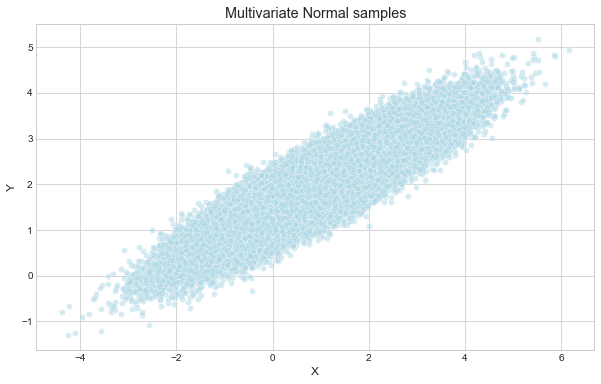

In [33]:
plt.scatter(x = MVN[:,0], y = MVN[:, 1], color = 'lightblue', alpha=0.5, edgecolors='white')
plt.ylabel("Y")
plt.xlabel("X")
plt.title("Multivariate Normal samples")
plt.show()

In [23]:
## pearson correlation statistic
stats.pearsonr(x=MVN[:,0], y = MVN[:,1])

(0.90108752379092438, 0.0)

In [24]:
## means and quantiles
summary(MVN)

 Min.: [-4.3795 -1.3   ]
 1st Qu.: [ 0.1948  1.4949]
 Median: [ 1.0105  2.0067]
 3rd Qu.: [ 1.8351  2.5176]
 Max.: [ 6.1484  5.1711]
 Mean: [ 1.0109  2.0056]


## Beta-Binomial revisited 

In the introduction to these notes, we saw a Bayesian example of the Beta-Binomial distribution. From Casella's paper *Explaining the Gibbs Sampler*, we revisit this example.

$$
X | \theta \sim Bin(n, \theta), \text{ and }\ \theta \sim Beta(a, b)
$$
have joint density
$$
f(x, \theta) = \binom{n}{x}\frac{\Gamma(a + b)}{\Gamma(a) \Gamma(b)} \theta^{x + a - 1} (1 - \theta)^{n - x + b -1}
$$
is the a $Beta(x+a, n-x+b)$ distribution.


## Beta-Binomial revisited 

Suppose we are interested in calculating some characteristics of the marginal distributions of $X | \theta$ and $\theta | a, b, x, n$. 

$$
f(x | \theta ) \text{ is } Bin(n, \theta) \\
f(\theta | x) \text{ is } Beta(x + a, n - x + b) 
$$

Therefore, we follow an iterative algorithm of 
$$
X_i \sim f(x | \theta) \\
\theta_{i+1} \sim f(\theta | X_i = x_i)
$$

## Beta-Binomial revisited 


In [46]:
N = 10**6
n = 16
a = 2
b = 4
X = np.zeros(N)
thetas = np.zeros(N)

runif = np.random.rand
rbinom = np.random.binomial
rbeta = np.random.beta

X[0] = runif(1) ## initial values
thetas[0] = runif(1) ## theta values

for i in range(1, N):
    X[i] = rbinom(size = 1, n = n, p = thetas[i-1])
    thetas[i] = rbeta(size = 1, a = a + X[i], b = n - X[i]+b)


In [47]:
summary(X)

 Min.: 0.0
 1st Qu.: 3.0
 Median: 5.0
 3rd Qu.: 8.0
 Max.: 16.0
 Mean: 5.3315


In [43]:
summary(thetas)

 Min.: 0.0007
 1st Qu.: 0.1923
 Median: 0.3123
 3rd Qu.: 0.4512
 Max.: 0.982
 Mean: 0.3314


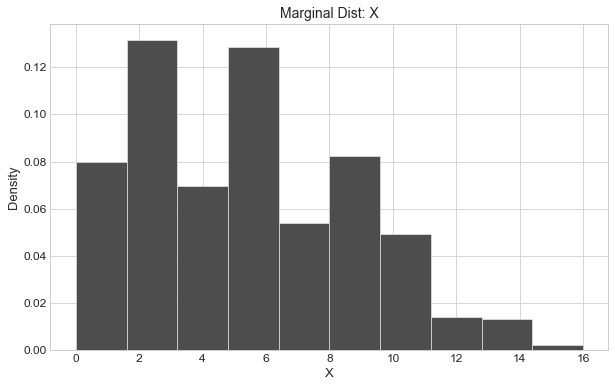

In [48]:
hist(X, title = "Marginal Dist: X", density = True)

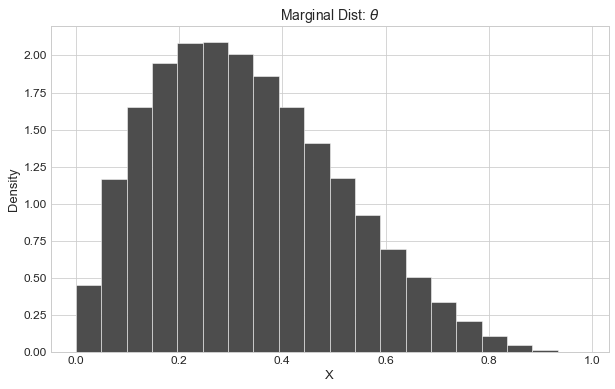

In [51]:
hist(thetas, title = r"Marginal Dist: $\theta$", bins = 20)


## The multistage Gibbs sampler 

There is a natural extension from the two-stage Gibs sampler to the general multistage Gibbs sampler. Suppose that, for some $p > 1$, the random variable $\mathbf{X} \in X$ can be written as $\mathbf{X} = (X_1, ..., X_p)^T$ where the $X_i$'s are either unidimensional or multidimensional components. Suppose that we can simulate from the corresponding conditional densities, $f_1, f_2, ..., f_p$ that is, we can simulate

$$
X_i | x_1, ..., x_{i-1}, x_{i+1}, ..., x_{p} \sim f(x_i | x_1, ..., x_{i-1}, x_{i+1}, ..., x_{p})
$$

for $i$ in 1, 2, ..., $p$. THe associated Gibbs sampler is given as


## The multistage Gibbs sampler 

At iteration $t =  1, 2, ...$, given $\mathbf{x^{(t)}} = (x^{(1)}, ..., x^{(p)})$, generate


`1.` $X_1^{(t+1)} \sim f_1(x_1 | x_2^{(t)}, ..., x_p^{(t)})$

`2.`  $X_2^{(t+1)} \sim f_2(x_2 | x_1^{(t+1)}, x_3^{(t)} ..., x_p^{(t)})$\
...

`p.` $X_p^{(t+1)} \sim f_p(x_p | x_1^{(t+1)}, ..., x_{p-1}^{(t+1)})$.

The densities $f_1, ..., f_p$ are called the *full conditionals*, and a particular feature of teh Gibbs sampler is that these are the only densities used for simulation. Thus, even in a high-dimensional problem, all of the simulations *may* be univariate, which can be a huge advantage!




In [ ]:

## Bayesian Change-Point Analysis 


Let's try to model a more interesting example, a time series of recorded coal mining disasters in the UK from 1851 to 1962, for $n = 111$ years of data. 
This analysis will follow the analysis layed out by Carlin et al in [Hierarchical Bayesian Analysis of Changepoint Problems](http://www.webpages.uidaho.edu/~stevel/565/literature/bayes_changepoint_poisson_1.pdf). 
Occurrences of disasters in the time series is thought to be derived from a Poisson process with a drop rate parameter in the later part of the time series. We are interested in locating the change point, $k$, in the series.



[Change Point Detection](https://en.wikipedia.org/wiki/Change_detection)



## Bayesian Change-Point Analysis 


```{r, fig.height=3, fig.width=5}
data_vector = c(4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 
                3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0, 
                1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 
                3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1)
n = length(data_vector)
disasters = ts(data_vector, freq=1, start = 1851)
plot(disasters, type = "h", lty = 6, lwd = 2, main = "Coal Mining Disasters", xlab = "Year", ylab = "Disasters")

```



## Bayesian Change-Point Analysis 

We are going to use Poisson random variables for this type of count data. Denoting year $i$'s accident count by $y_i$,
$$
y_i \sim \text{Poisson}(\Lambda)
$$



The modeling problem revolves around estimating the values of the $\lambda$ parameters. 
Looking at the time series above, it appears that the rate declines later in the time series.
A changepoint model identifies a point (year) during the observation period ($k$) after which the 
parameter $\lambda$ drops to a lower value. So we are estimating two $\lambda$ parameters: 
one for the early period and another for the late period.

$$
\Lambda = 
\begin{cases}
\theta  \text{ if } i < k \\
\lambda  \text{ if } i \geq k \\
\end{cases}
$$




## Bayesian Change-Point Analysis 

We need to assign prior probabilities to both $\theta$ and $\lambda$ parameters. 
The gamma distribution not only provides a continuous density function for positive numbers, 
but it is also conjugate with the Poisson sampling distribution.


We will specify suitably vague hyperparameters, letting $\alpha = 1$ and allowing $\beta$s to vary.
$$
\begin{aligned}
&\theta \sim \text{Gamma}( 1, b_1 ) \\\
&\lambda \sim \text{Gamma}( 1, b_2 )
\end{aligned}
$$


## Bayesian Change-Point Analysis 

Since we do not have any intuition about the location of the changepoint (prior to viewing the data), we will assign a discrete uniform prior over all years 1851-1962.
$$
\begin{aligned}
\ & k \sim \text{Unif(1851,1962) }\\\\
\ & \Rightarrow p( K = k ) = \frac{1}{111}
\end{aligned}
$$


## Implementing Gibbs sampling  

We are interested in estimating the joint posterior of $\theta, \lambda$ and $k$ given the array of annnual disaster counts $\mathbf{y}$. This gives:
$$
p( \theta, \lambda, k | \mathbf{y} ) \propto p(\mathbf{y} | \theta, \lambda, k ) p(\theta, \lambda, k) 
$$

To employ Gibbs sampling, we need to factor the joint posterior into the product of conditional expressions:

$$
\displaystyle p( \theta, \lambda, k | \mathbf{y} ) \propto p(y_{i < k} | \theta, k) p(y_{i \geq k} | \lambda, k) p(\theta) p(\lambda) p(k)
$$

which we have specified as:

$$
\begin{aligned}
p( \theta, \lambda, k | \mathbf{y} ) & \propto \left[\prod_{t=1851}^{k} \text{Poisson}(y_i|\theta) \times \prod_{t=k+1}^{1962} \text{Poisson}(y_i|\lambda) \right] \times \text{Gamma}(\theta|\alpha,\beta) \times \text{Gamma}(\lambda|\alpha, \beta) \frac{1}{111} \\
\ & \propto \left[\prod_{t=1851}^{k} e^{-\theta}\theta^{y_i} \prod_{t=k+1}^{1962} e^{-\lambda} \lambda^{y_i} \right] \theta^{\alpha-1} e^{-\beta\theta} \lambda^{\alpha-1} e^{-\beta\lambda} \\
\ & \propto \theta^{\sum_{t=1851}^{k} y_i +\alpha-1} e^{-(\beta+k)\theta} \lambda^{\sum_{t=k+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda}
\end{aligned}
$$


## Implementing Gibbs sampling  

So, the full conditionals are known, and critically for Gibbs, can easily be sampled from.
$$
\theta \sim \text{Gamma} \left(\sum_{t=1851}^{k} y_i +\alpha, k+\beta \right)
$$



$$
\lambda \sim \text{Gamma} \left(\sum_{t=k+1}^{1962} y_i + \alpha, 1962-k+\beta \right)
$$


$$
\begin{aligned}
p(k | \mathbf{y}, \theta, \lambda, b_1, b_2) & = \frac{L(\mathbf{y} | \theta, \lambda, b_1, b_2) }{\sum_{j=1}^n L(\mathbf{y} | \theta, \lambda, b_1, b_2 ) }
\end{aligned}
$$
where the likelihood is defined as

$$
\displaystyle L(\mathbf{y} | \theta, \lambda, b_1, b_2) = e^{(\lambda - \theta)} \left( \frac{\theta}{\lambda} \right)^{\sum_1^k y_i}
$$


## Implementing Gibbs sampling  

```{r}
set.seed(123)

y = data_vector
# Gibbs sampler for the coal mining change point
# initialization
n <- length(y) #length of the data
m <- 10^4 #length of the chain

## vectors to hold data
theta <- numeric(m) 
lambda <- numeric(m) 
k <- numeric(m)
L <- numeric(n)

## initial values
k[1] <- sample(1:n, 1) ## change-points
theta[1] <- 1
lambda[1] <- 1
a = 0.5
b1 <- 1
b2 <- 1

```


## Implementing Gibbs sampling  

The algorithm explained by Carlin et al is simple. For $t \in \{1, 2, ..., m \}$

1. Sample $\displaystyle \theta_t \sim Gamma(a_1 + \sum_1^{k} y_i, k_{t-1} + b_{1, t-1})$

2. Sample $\displaystyle \lambda_t \sim Gamma(a_2 + \sum_{k+1}^n y_i, n - k_{t-1} + b_{2, t-1} )$

3. Sample $\displaystyle b_1 \sim Gamma(a_1 + c_1, (\theta_t + d_1))$

4. Sample $\displaystyle b_2 \sim Gamma(a_2 + c_2, (\lambda_t + d_2))$

5. For $j \in {1, ..., n}$ calculate $L(\mathbf{y} | \theta, \lambda, b_1, b_2)$, from there you'll obtain $p(k | \mathbf{y}, \theta, \lambda, b_1, b_2)$

6. Sample $k_t \sim p(k | \mathbf{y}, \theta, \lambda, b_1, b_2)$



## Implementing Gibbs sampling  

```{r}

# run the Gibbs sampler
for (t in 2:m){
    kt <- k[t-1]
    #generate theta
    r <- a + sum(y[1:kt])
    theta[t] <- rgamma(1, shape = r, rate = kt + b1)
    #generate lambda
    if (kt + 1 > n){ 
      r <- a + sum(y) 
      }else{
        r <- a + sum(y[(kt+1):n])
      }
    lambda[t] <- rgamma(1, shape = r, rate = n - kt + b2)
    #generate b1 and b2
    b1 <- rgamma(1, shape = a, rate = theta[t]+1)
    b2 <- rgamma(1, shape = a, rate = lambda[t]+1)

    for (j in 1:n) {
        L[j] <- exp((lambda[t] - theta[t]) * j) * 
                (theta[t] / lambda[t])^sum(y[1:j])
    }
    L <- L / sum(L)
    #generate k from discrete distribution L on 1:n
    k[t] <- sample(1:n, prob=L, size=1)
}

```



## Implementing Gibbs sampling  

Set a burn-in of 1000 samples. We will use burn in to toss out "poor" samples from out Markov chain. Arguments for and against burn-in vary. Statisticians, Andrew Gelman ([Burn-in Man](http://andrewgelman.com/2008/09/06/burnin_man/)) and Charlie Geyer ([Burn-In](http://users.stat.umn.edu/~geyer/mcmc/burn.html)) provide some commentary on burn-in.

```{r}
## set burn in
burn_in <- 1000
## will toss out first 1000 samples

K <- k[burn_in:m]

## mean
print(mean(K))
#[1] 39.935

## mode
print(which.max(table(K)))
```


## Implementing Gibbs sampling  

```{r}
plot(K, type="l", col="gray", main = "Change-Point",
     xlab="Iteration", ylab = "K")
lines(1:length(K), cumsum(K) / (1:length(K)))
```



## Implementing Gibbs sampling  

```{r}
print(mean(lambda[burn_in:m])) #[1] 0.9341033
print(mean(theta[burn_in:m])) #[1] 3.108575

```



## Implementing Gibbs sampling  

```{r, echo=FALSE, fig.height=4}
## Code for Figure 9.12 on page 276
# histograms from the Gibbs sampler output
par(mfrow=c(1,3))

hist(theta[burn_in:m], main="", xlab = expression(theta), 
     col="gray", border="white",
     breaks = "scott", prob=TRUE) #theta posterior

hist(lambda[burn_in:m], main="", xlab = expression(lambda),
     col="gray", border="white",
     breaks = "scott", prob=TRUE) #lambda posterior

hist(K, breaks=min(K):max(K), prob=TRUE, main="",
     col="gray", border="white",
     xlab = "k")

```



Our analysis can be used to justify that the change point occurs at some range at the $41^{st}$ year, 1891, which is similar to other analyses cited by Carlin et al.


## Implementing Gibbs sampling  


```{r, eval=FALSE}

hist(theta[burn_in:m], main="", xlab = expression(mu), 
     col="gray", border="white",
     breaks = "scott", prob=TRUE) #mu posterior

hist(lambda[burn_in:m], main="", xlab = expression(lambda),
     col="gray", border="white",
     breaks = "scott", prob=TRUE) #lambda posterior

hist(K, breaks=min(K):max(K), prob=TRUE, main="",
     col="gray", border="white",
     xlab = "k")

```


